In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

import os
import joblib
import random
from tqdm import tqdm
import cv2
import numpy as np

In [ ]:
DATA_DIR = 'D:\Documents\CVPR\DataSets\CatDog'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'training_set/training_set')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test_set/test_set')

In [ ]:
IMG_SIZE = 64
CATEGORIES = []

for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
    
print(CATEGORIES)

['cats', 'dogs']


In [ ]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c) # 0
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   # read the image
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize the image
            training_data.append([img_resized, class_num]) # [ [img, 0], [], [], [], ...., []]
        except Exception as e:
            pass
        
print(len(training_data))

100%|█████████████████████████████████████████████████████████████████████████████| 4006/4006 [00:17<00:00, 233.72it/s]

8005


In [ ]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass
        
print(len(test_data))

100%|█████████████████████████████████████████████████████████████████████████████| 1013/1013 [00:05<00:00, 196.83it/s]

2023


In [ ]:
random.shuffle(training_data)
random.shuffle(test_data)

In [ ]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)
    
X_train = np.array(X_train).astype('float32').reshape(-1,64,64,3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (8005, 64, 64, 3) Y_train= (8005,)


In [ ]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_test= (2023, 64, 64, 3) Y_test= (2023,)


In [ ]:
mean_rgb = np.mean(X_train, axis=(0,1,2))
print(mean_rgb)

[ 99.915855 112.19985  123.27315 ]


In [ ]:
X_train_norm = np.empty_like(X_train)
X_test_norm = np.empty_like(X_test)

for i in range(len(X_train)):
    for c in range(3):
        if(c==1):
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[0]
        elif(c==2):
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[1]
        else:
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[2]
            
for i in range(len(X_test)):
    for c in range(3):
        if(c==1):
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[0]
        elif(c==2):
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[1]
        else:
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[2]

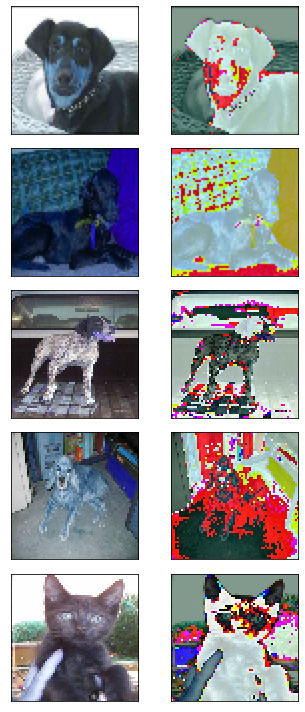

In [ ]:
import matplotlib.pyplot as plt
c = 0
plt.figure(figsize=(5,10))
for i in range(5):
    plt.subplot(5,2,c+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(5,2,c+2)
    plt.imshow(X_train_norm[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    c += 2
    
plt.tight_layout()
plt.show()

In [ ]:
model = keras.Sequential([
    
    keras.Input(shape=X_train_norm.shape[1:]),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    
    
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    
    
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    
        
    
    layers.Flatten(),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(10),
    layers.Activation('softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 128)       0

In [ ]:
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
cb = EarlyStopping(monitor='val_loss', min_delta=0.02, patience=3, restore_best_weights=True)

h = model.fit(x=X_train_norm, y=Y_train, 
              epochs=2, 
              validation_split=0.2,
              batch_size=64,
              callbacks=[cb]
             )

Epoch 1/2
101/101 [==============================] - 529s 5s/step - loss: 0.7548 - accuracy: 0.5052 - val_loss: 0.7041 - val_accuracy: 0.4878
Epoch 2/2
101/101 [==============================] - 500s 5s/step - loss: 0.6996 - accuracy: 0.4991 - val_loss: 0.6972 - val_accuracy: 0.4878


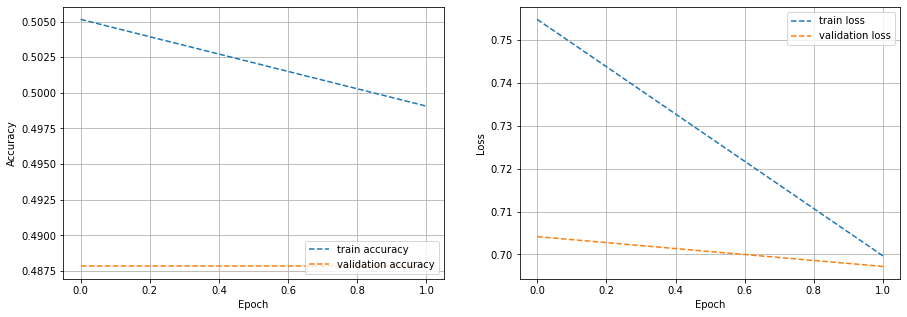

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], '--', label='train accuracy')
plt.plot(h.history['val_accuracy'], '--', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], '--', label='train loss')
plt.plot(h.history['val_loss'], '--', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()